# Testing

A large-ish notebook that does some, mostly qualitative, testing of various _explorationlib_ functions.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/parenthetical-e/explorationlib/blob/main/explorationlib/testing.ipynb)

# Setup 

## colab
If this is running on colab, uncomment and run the below.

In [ ]:
# !pip install git+https://github.com/parenthetical-e/explorationlib
# !pip install celluloid # for the gifs

## Imports

In [4]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib
from explorationlib import agent
from explorationlib import local_gym as gym

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import show_gif

from explorationlib import score
from explorationlib.score import search_efficiency
from explorationlib.score import first_reward
from explorationlib.score import average_reward
from explorationlib.score import total_reward

## Config notebook

In [5]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True

plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

In [6]:
# Uncomment for local development
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

# Make "data"
Used throughout.

In [4]:
if not os.path.exists("data"):
    os.makedirs("data")

<IPython.core.display.Javascript object>

# Test - random search agents - 1
- First use the `gym.Field`, an open space. Verify the step length distributions, and qualitative behave/position data

In [22]:
# How long to run? Longer is better, but slower.
num_steps = 100000
step_size = 0.1
detection_radius = 0.5
min_length = 0.1

# Cleanup old versions
for path in glob.glob("data/test1_*.pkl"):
    os.remove(path)
    
# Create env and agents
env = gym.Field()
diffusion = agent.Diffusion2d(min_length=min_length, scale=0.5, detection_radius=detection_radius, step_size=step_size)
levy = agent.Levy2d(min_length=min_length, exponent=2, detection_radius=detection_radius,step_size=step_size)

# !
experiment("data/test1_levy.pkl", levy, env, num_steps=num_steps, num_experiments=1)
experiment("data/test1_diffusion.pkl", diffusion, env, num_steps=num_steps, num_experiments=1)

# Load the results
levy_exp = load("data/test1_levy.pkl")
brown_exp = load("data/test1_diffusion.pkl")

test1_diffusion: 100%|██████████| 1/1 [00:03<00:00,  3.01s/it]


<IPython.core.display.Javascript object>

### show available data from the experiment

In [23]:
levy_exp.keys()

dict_keys(['exp_step', 'num_experiment', 'exp_state', 'exp_action', 'exp_reward', 'exp_info', 'agent_num_turn', 'agent_angle', 'agent_l', 'agent_step', 'agent_num_step', 'agent_action', 'exp_name', 'num_experiments', 'exp_num_steps', 'env', 'agent'])

<IPython.core.display.Javascript object>

# Env and Agent log are the same size?

In [24]:
assert len(levy_exp["exp_reward"]) == len(levy_exp["agent_l"])

<IPython.core.display.Javascript object>

### plot position data

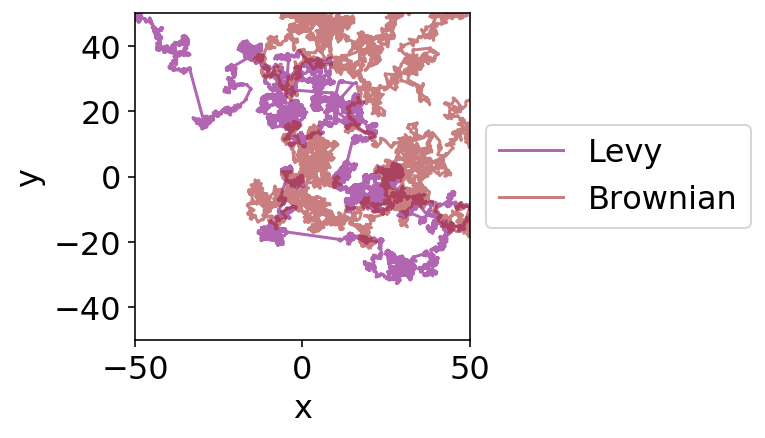

<IPython.core.display.Javascript object>

In [25]:
plot_boundary = (50, 50)

ax = None
ax = plot_position2d(
    levy_exp,
    boundary=plot_boundary,
    label="Levy",
    color="purple",
    alpha=0.6,
    ax=ax,
)
ax = plot_position2d(
    brown_exp,
    boundary=plot_boundary,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)

In [26]:
max(brown_exp['agent_num_turn'])

15254

<IPython.core.display.Javascript object>

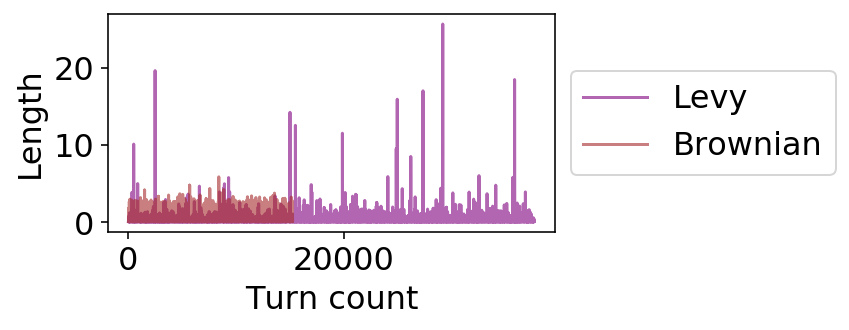

<IPython.core.display.Javascript object>

In [30]:
plot_boundary = (200, 200)

ax = None
ax = plot_length(
    levy_exp,
    label="Levy",
    color="purple",
    alpha=0.6,
    ax=ax,
)
ax = plot_length(
    brown_exp,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)

### plot loglog length distributions

- _Uniform_ should be flat(ish) still
- _Diffusion_ should drop of quick for large l
- _Levy_ should be a downward going straight line

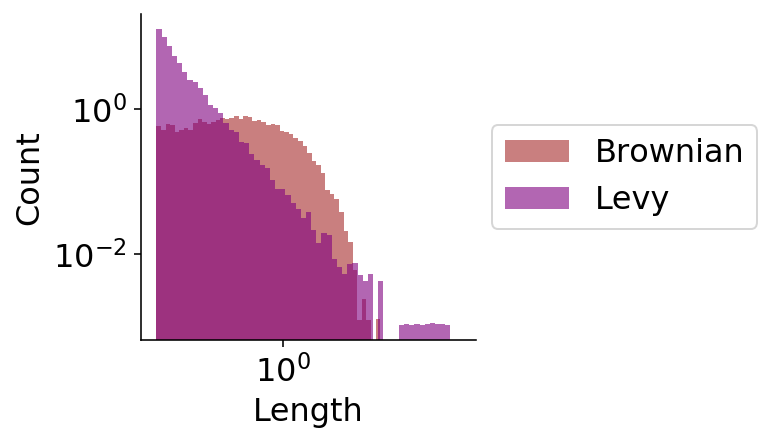

<IPython.core.display.Javascript object>

In [31]:
ax = None
ax = plot_length_hist(
    brown_exp,
    loglog=True,
    bins=50,
    density=True,
    alpha=0.6,
    color="brown",
    label="Brownian",
    ax=ax,
)
ax = plot_length_hist(
    levy_exp,
    loglog=True,
    bins=60,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
)
sns.despine()

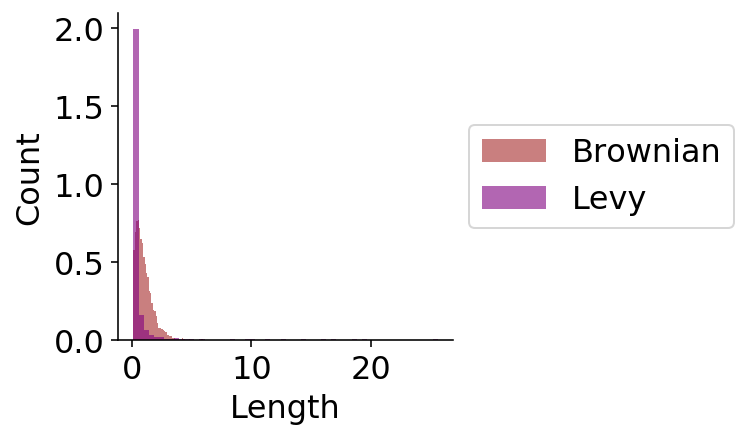

<IPython.core.display.Javascript object>

In [32]:
ax = None
ax = plot_length_hist(
    brown_exp,
    loglog=False,
    bins=50,
    density=True,
    alpha=0.6,
    color="brown",
    label="Brownian",
    ax=ax,
)
ax = plot_length_hist(
    levy_exp,
    loglog=False,
    bins=60,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
)
sns.despine()

# Test - random search agents - 2
- Next use the `gym.Field` with various (bounded) target distributions. Verify target gathering performance across agents. 
- The parameter of interest here is the detection radius.

In [5]:
detection_radius = 2
target_boundary = (50, 50)

env = gym.Field()
targets = gym.uniform_targets(500, target_boundary)
values = gym.constant_values(targets, 1)

env.add_targets(targets, values, detection_radius=detection_radius)

<IPython.core.display.Javascript object>

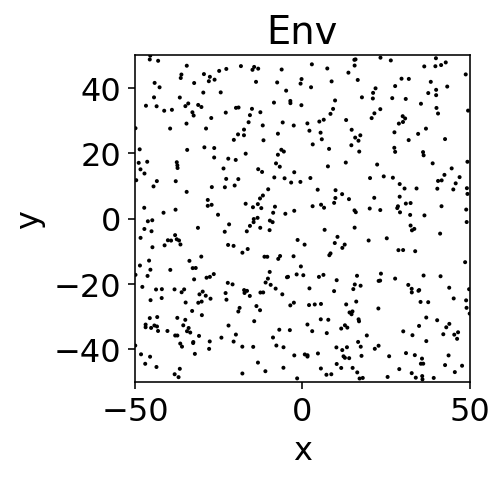

<IPython.core.display.Javascript object>

In [6]:
plot_targets2d(env, boundary=target_boundary, title="Env")

Values should be 1

In [7]:
values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

<IPython.core.display.Javascript object>

### Run repeated experiments
For _num_steps_.

In [46]:
# Experiment settings
num_experiments = 100
num_steps = 10000
num_targets = 500
step_size = 0.1
detection_radius = 0.25

# Speed up the search; use TruncatedLevy2d
min_length = 0.5
max_length = 20

# Env
env = gym.Field()

# Targets
target_boundary = (50, 50)
targets = gym.uniform_targets(num_targets, target_boundary)
values = gym.constant_values(targets, 1)
env.add_targets(targets, values, detection_radius=detection_radius)

# Agents
brown = agent.Diffusion2d(min_length=min_length,
                          scale=.1,
                          detection_radius=detection_radius, step_size=step_size)
levy2 = agent.Levy2d(min_length=min_length,
                            #   max_length=max_length,
                              exponent=2,
                              detection_radius=detection_radius, step_size=step_size)

# Cleanup 
for path in glob.glob("data/test2_*.pkl"):
    os.remove(path)

# !
levy2_data = experiment(
    f"data/test2_levy2.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
)
brown_data = experiment(
    f"data/test2_brown.pkl",
    brown,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
)

test2_brown: 100%|██████████| 100/100 [05:32<00:00,  3.32s/it]


<IPython.core.display.Javascript object>

### Plot a select experiment

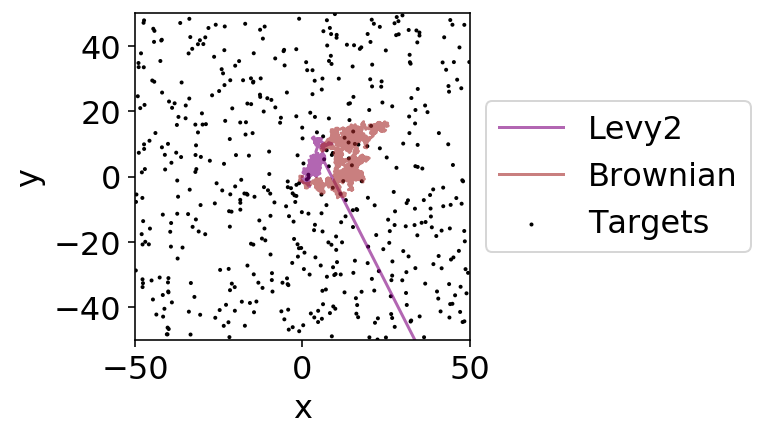

<IPython.core.display.Javascript object>

In [47]:
plot_boundary = (50, 50)

num_experiment = 10
ax = plot_position2d(
    select_exp(levy2_data, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(brown_data, num_experiment),
    boundary=plot_boundary,
    label="Brownian",
    color="brown",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

## Plot agents, by targets

In [48]:
# Results, names, and colors
results = [levy2_data, brown_data]
names = ["Levy", "Diffusion"]
colors = ["purple", "brown"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    # r = search_efficiency(res)
    # r = first_reward(res)
    r = total_reward(res)
    scores.append(r)   

<IPython.core.display.Javascript object>

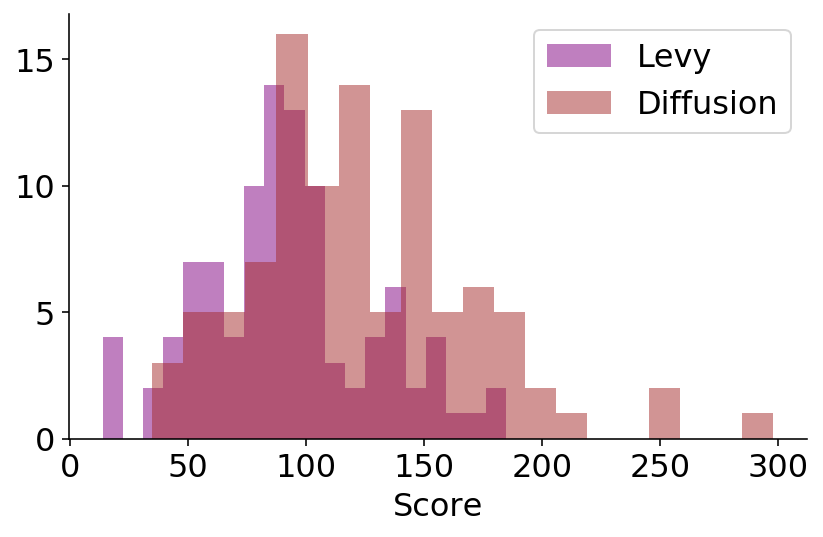

<IPython.core.display.Javascript object>

In [49]:
# Dists
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=20)
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

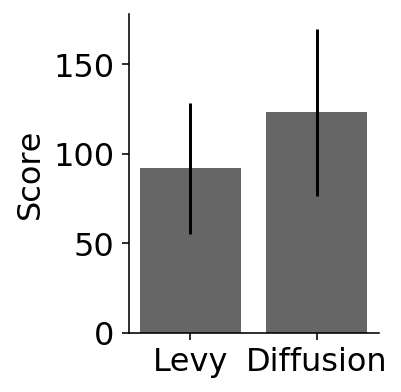

<IPython.core.display.Javascript object>

In [50]:
# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Score")
plt.tight_layout()
sns.despine()

In [37]:
# names = ["Levy", "Brownian"]

# # Score by eff
# scores = []
# for a in [levy2, brown]:
#     r = search_efficiency(a)
#     scores.append(r)

#     # Tabulate
#     m = []
#     sd = []
#     for i, s in enumerate(scores):
#         m.append(np.mean(s))
#         sd.append(np.std(s))

# # Plot
# fig = plt.figure(figsize=(3, 3))
# plt.bar(names, m, yerr=sd, color="black", alpha=0.7)
# plt.ylabel("Score")
# plt.tight_layout()
# sns.despine()

<IPython.core.display.Javascript object>

## Replay an experiment
AKA make a science gif.

In [31]:
num_experiment = 0
name = f"data/test2_levy_replay.gif"
os.remove(name)

%matplotlib agg
render_2d(name, env, levy2, num_experiment, interval=5)
%matplotlib inline

show_gif(name)

FileNotFoundError: [Errno 2] No such file or directory: 'data/test2_levy_replay.gif'

# Test - random search agents - 3
## Scan the Levy exponent
For sparse renewing targets, small detection radius, a classic ressult is optimal search eff at u=2. Prove that holds.

Params take from (as much as possible):

> Viswanathan, G. M. et al. Optimizing the success of random searches. Nature 401, 911–914 (1999).

In [ ]:
detection_radius = 0.25
target_boundary = (50, 50)

env = gym.Field()
targets = gym.uniform_targets(500, target_boundary)
values = gym.constant_values(targets, 1)

env.add_targets(targets, values, detection_radius=detection_radius)

<IPython.core.display.Javascript object>

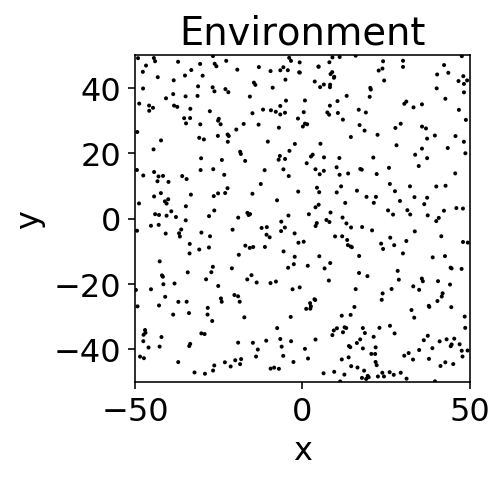

<IPython.core.display.Javascript object>

In [ ]:
plot_targets2d(env, boundary=target_boundary, title="Environment")

In [ ]:
# Params
num_experiments = 100
num_steps = 1000
exponents = [1.01, 1.50, 2.00, 2.50, 2.99]
# Speed up
min_length = 0.1
max_length = 10
seed = None

<IPython.core.display.Javascript object>

In [ ]:
# Cleanup old versions
for path in glob.glob("data/levy*_scan.pkl"):
    os.remove(path)


# !
scores = []
for x in exponents:
    # Init
    exp_name = f"data/levy{x}_scan.pkl"
    
    # Init
    levy = agent.TruncatedLevy2d(min_length=min_length,
                                 max_length=max_length,
                                 exponent=x,
                                 detection_radius=detection_radius)
    # Run repeats
    experiment(
        exp_name,
        levy,
        env,
        num_steps=num_steps,
        num_experiments=num_experiments,
        seed=seed,
    )

levy2.99_scan: 100%|██████████| 100/100 [00:19<00:00,  5.20it/s]


<IPython.core.display.Javascript object>

In [ ]:
# load
results = []
for i, x in enumerate(exponents):
    exp_data = load(f"data/levy{x}_scan.pkl")
    results.append(exp_data)

<IPython.core.display.Javascript object>

In [ ]:
[r["exp_name"] for r in results]

['levy1.01_scan',
 'levy1.5_scan',
 'levy2.0_scan',
 'levy2.5_scan',
 'levy2.99_scan']

<IPython.core.display.Javascript object>

## Visualize steps

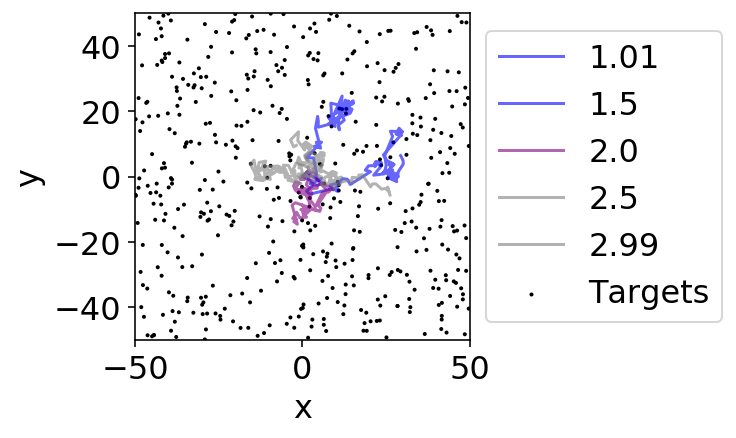

<IPython.core.display.Javascript object>

In [ ]:
num_experiment = 5
plot_boundary = (50, 50)

colors = ["blue", "blue", "purple", "grey", "grey"]
ax = None
for i, r in enumerate(results):
    ax = plot_position2d(
        select_exp(r, num_experiment),
        boundary=plot_boundary,
        label=str(exponents[i]),
        color=colors[i],
        alpha=0.6,
        figsize=(3, 3),
        ax=ax
    )

ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)   

## Length histogram

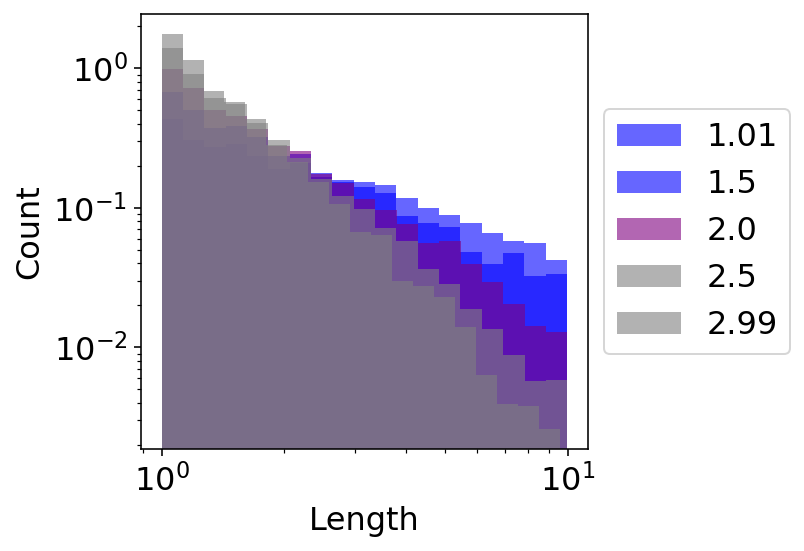

<IPython.core.display.Javascript object>

In [ ]:
num_experiment = 5
plot_boundary = (50, 50)

colors = ["blue", "blue", "purple", "grey", "grey"]
ax = None
for i, r in enumerate(results):
    ax = plot_length_hist(
        # r,
        select_exp(r, num_experiment),
        label=str(exponents[i]),
        color=colors[i],
        alpha=0.6,
        loglog=True,
        figsize=(4, 4),
        ax=ax
    )

## Search eff

In [ ]:
# Score by eff
scores = []
for r in results:
    eff = search_efficiency(r)
    scores.append(eff)

    # Tabulate
    m = []
    sd = []
    for i, s in enumerate(scores):
        m.append(np.mean(s))
        sd.append(np.std(s))

<IPython.core.display.Javascript object>

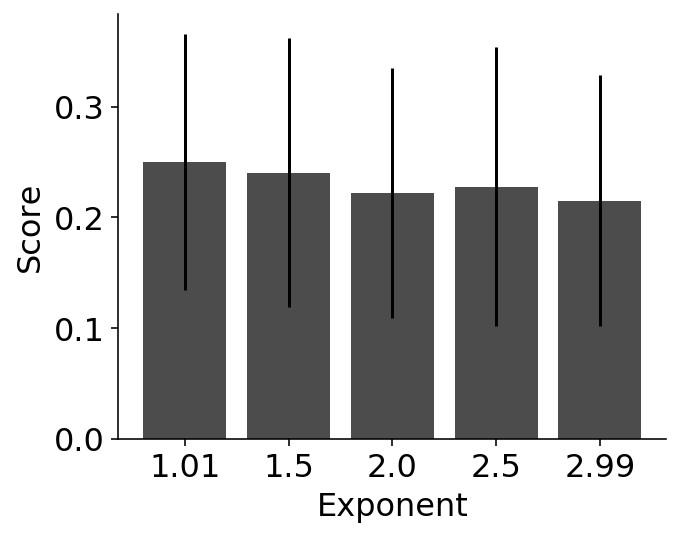

<IPython.core.display.Javascript object>

In [ ]:
# Plot
fig = plt.figure(figsize=(5, 4))

plt.bar([str(x) for x in exponents], m, yerr=sd, color="black", alpha=0.7)
plt.ylabel("Score")
plt.xlabel("Exponent")
plt.tight_layout()
sns.despine()

# Testing - cardinal/discrete agents - 4  


In [33]:
# Experiment settings
num_experiments = 1
num_steps = 10000


detection_radius = 1

# Speed up the search; use TruncatedLevy2d
min_length = 1
max_length = 10

# Env
env = gym.CardinalGrid()

diff = agent.DiffusionDiscrete(min_length=min_length, scale=1)
levy2 = agent.TruncatedLevyDiscrete(min_length=min_length, max_length=max_length, exponent=2)

# Cleanup 
for path in glob.glob("data/test4_*.pkl"):
    os.remove(path)

# !
levy2_exp = experiment(
    f"data/test4_levy.pkl",
    levy2,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
)
diff_exp = experiment(
    f"data/test4_diff.pkl",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
)

test4_diff: 100%|██████████| 1/1 [00:00<00:00,  1.97it/s]


<IPython.core.display.Javascript object>

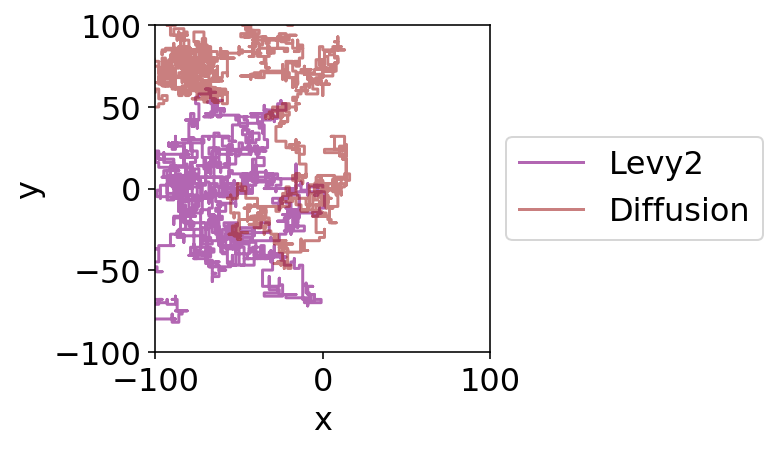

<IPython.core.display.Javascript object>

In [35]:
plot_boundary = (100, 100)

num_experiment = 0
ax = plot_position2d(
    select_exp(levy2_exp, num_experiment),
    boundary=plot_boundary,
    label="Levy2",
    color="purple",
    alpha=0.6,
    figsize=(3, 3),
)
ax = plot_position2d(
    select_exp(diff_exp, num_experiment),
    boundary=plot_boundary,
    label="Diffusion",
    color="brown",
    alpha=0.6,
    ax=ax,
)

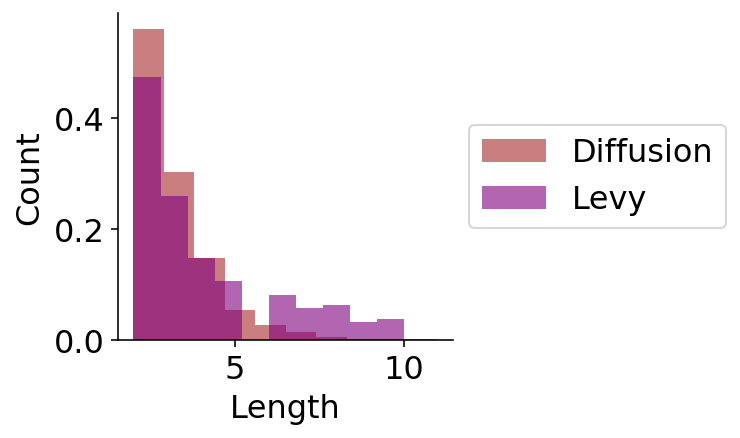

<IPython.core.display.Javascript object>

In [37]:
ax = None
ax = plot_length_hist(
    diff_exp,
    loglog=False,
    bins=10,
    density=True,
    alpha=0.6,
    color="brown",
    label="Diffusion",
    ax=ax,
)
ax = plot_length_hist(
    levy2_exp,
    loglog=False,
    bins=10,
    density=True,
    alpha=0.6,
    label="Levy",
    color="purple",
    ax=ax,
)
sns.despine()